In [3]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jacfwd, jacrev, hessian
from jax import jit
import matplotlib.pyplot as plt

(array([  1.,   0.,   7.,  11.,  18.,  42.,  51.,  86., 121., 132., 138.,
        115., 113.,  75.,  46.,  17.,  10.,  13.,   3.,   1.]),
 array([-3.48080883, -3.13815357, -2.79549832, -2.45284307, -2.11018781,
        -1.76753256, -1.4248773 , -1.08222205, -0.7395668 , -0.39691154,
        -0.05425629,  0.28839897,  0.63105422,  0.97370947,  1.31636473,
         1.65901998,  2.00167524,  2.34433049,  2.68698575,  3.029641  ,
         3.37229625]),
 <BarContainer object of 20 artists>)

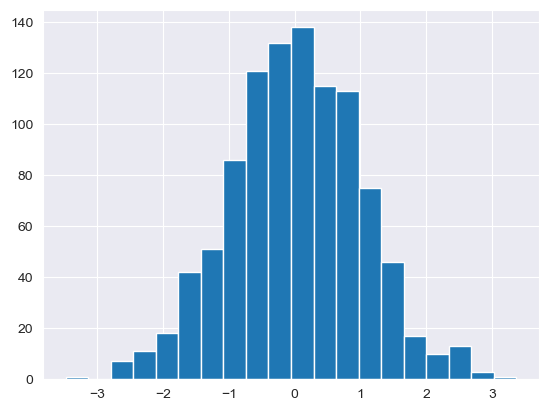

In [137]:
#test out np.random. Generate 100 point and cast it to check if it follows the bell curve
X = np.random.randn(1000)
plt.hist(X, bins=20)


### Generate points based on desired polynomial with some error

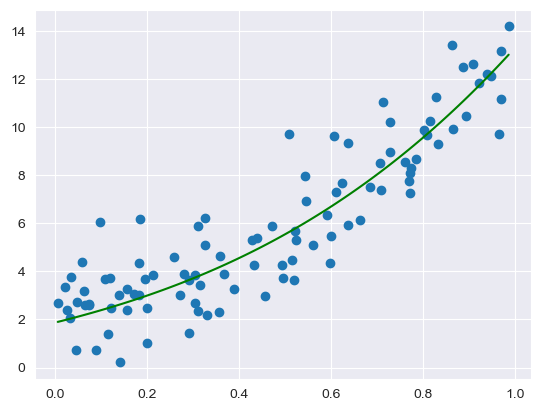

In [148]:
#set the random_seed
np.random.seed(42)

def function(params,x):
    return params[0] + params[1] * x + params[2] * x ** 2 + params[3] * x ** 3

def generate_points(params,n, error):
    X = np.random.rand(n)
    Y = function(params,X) + error*np.random.randn(n)
    return X, Y

params = np.random.rand(4)*5
X, Y = generate_points(params,100, 1.5)
#plot the function as well
X_org = jnp.linspace(min(X), max(X), 100)
Y_org = function(params,X_org)
plt.plot(X_org, Y_org, color='green', label='Function')
plt.scatter(X, Y)

## Polynomial regression using Newton's method

In [149]:
def predict(params, X):
    #third polynomial
    return params[0] + params[1] * X + params[2] * X ** 2 + params[3] * X ** 3

# Define the loss function (mean squared error)
def loss(params, X, Y):
    predictions = predict(params, X)
    return jnp.mean((predictions - Y) ** 2)

# Compute the gradient and Hessian of the loss function
grad_loss = jit(grad(loss))
hessian_loss = hessian(loss)

# Newton's method for polynomial regression
def newton_method(X, Y, num_iterations=10):
    #random initialization of the parameters using random function from np
    params = np.random.rand(3)
    for i in range(num_iterations):
        grad_l = grad_loss(params, X, Y)
        hess_l = hessian_loss(params, X, Y)
        print(hess_l)
        
        #Add the damping factor to the hessian matrix to ensure that we are heading to teh minimum point.
        while jnp.any(jnp.linalg.eigvals(hess_l) <= 0):
            hess_l += 0.1 * jnp.eye(len(params))
        if jnp.linalg.cond(hess_l) < 1 / jnp.finfo(hess_l.dtype).eps:
            print(jnp.linalg.inv(hess_l))
            params_new = params - jnp.linalg.solve(hess_l, grad_l)
        else:
            print("Hessian is not invertible.")
            break
        params = params_new

        print(f"Iteration {i+1}, Parameters: {params}",)

    return params

def showNewton(X, Y):
    params = newton_method(X, Y)
    print("Final parameters:", params)

    #get the array of error for each X value
    error = Y - predict(params, X)

    # Plot the original data and the fitted curve
    plt.scatter(X, Y, color='red', label='Data points')
    X_fit = jnp.linspace(min(X), max(X), 100)
    Y_fit = predict(params, X_fit)
    plt.plot(X_fit, Y_fit, color='blue', label='Fitted curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    return X_fit,Y_fit,error

[[2.         0.91705865 1.0327547 ]
 [0.91705865 0.59387225 0.78614414]
 [0.5938723  0.4388825  0.6338862 ]]
[[  3.3703663 -13.734898   11.542841 ]
 [-12.274956   70.195816  -67.05779  ]
 [  5.341173  -35.733448   37.192036 ]]
Iteration 1, Parameters: [2.4827504 2.729531  4.1645665]
[[2.         0.91705865 1.0327547 ]
 [0.91705865 0.59387225 0.78614414]
 [0.5938723  0.4388825  0.6338862 ]]
[[  3.3703663 -13.734898   11.542841 ]
 [-12.274956   70.195816  -67.05779  ]
 [  5.341173  -35.733448   37.192036 ]]
Iteration 2, Parameters: [2.4827425 2.7295692 4.164548 ]
[[2.         0.91705865 1.0327547 ]
 [0.91705865 0.59387225 0.78614414]
 [0.5938723  0.4388825  0.6338862 ]]
[[  3.3703663 -13.734898   11.542841 ]
 [-12.274956   70.195816  -67.05779  ]
 [  5.341173  -35.733448   37.192036 ]]
Iteration 3, Parameters: [2.4827423 2.7295706 4.164547 ]
[[2.         0.91705865 1.0327547 ]
 [0.91705865 0.59387225 0.78614414]
 [0.5938723  0.4388825  0.6338862 ]]
[[  3.3703663 -13.734898   11.542841 ]


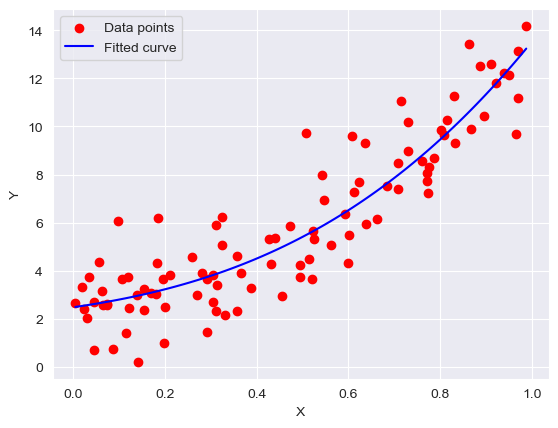

In [150]:
X_init_fit,Y_init_fit,error_init_fit = showNewton(X,Y)

0.2238866


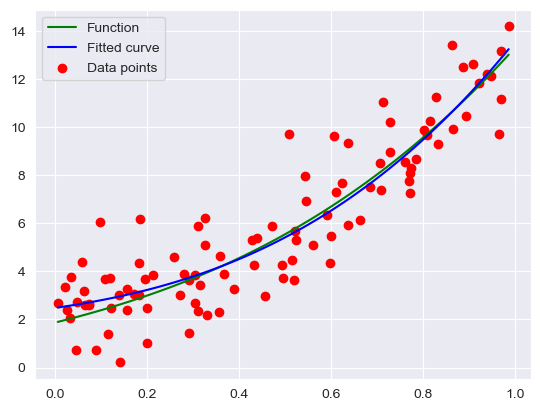

In [151]:
#Cast the original graph and the generated graph and get the error
X_comp = jnp.linspace(min(X), max(X), 100)
plt.plot(X_org, Y_org, color='green', label='Function')
plt.plot(X_init_fit,Y_init_fit, color='blue', label='Fitted curve')
plt.scatter(X, Y, color='red', label='Data points')
plt.legend()
#RMSE error between two graph
rmse = jnp.sqrt(jnp.mean((Y_org - Y_init_fit) ** 2))
print(rmse)

### Add outliers to the data

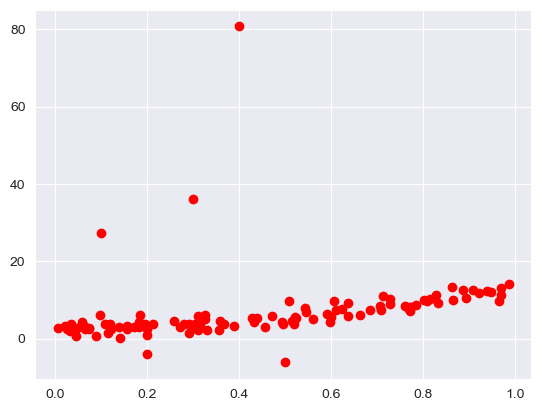

In [152]:
#set the random_seed
np.random.seed(42)
#Add outliers
X_outliers = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
Y_outliers = function(params,X_outliers) + 50*np.random.randn(len(X_outliers))
X_ol = np.concatenate((X, X_outliers))
Y_ol = np.concatenate((Y, Y_outliers))
#plot
plt.scatter(X_ol, Y_ol, color='red', label='Data points')

[[2.         0.9019607  0.9983379 ]
 [0.9019607  0.5760689  0.7548592 ]
 [0.5760689  0.42226908 0.60640883]]
[[  3.4063685 -13.967609   11.778973 ]
 [-12.487898   71.0364    -67.86731  ]
 [  5.4599304 -36.19698    37.71839  ]]
Iteration 1, Parameters: [3.2045963 7.7333384 0.3764937]
[[2.         0.9019607  0.9983379 ]
 [0.9019607  0.5760689  0.7548592 ]
 [0.5760689  0.42226908 0.60640883]]
[[  3.4063685 -13.967609   11.778973 ]
 [-12.487898   71.0364    -67.86731  ]
 [  5.4599304 -36.19698    37.71839  ]]
Iteration 2, Parameters: [3.2045946  7.7333484  0.37648806]
[[2.         0.9019607  0.9983379 ]
 [0.9019607  0.5760689  0.7548592 ]
 [0.5760689  0.42226908 0.60640883]]
[[  3.4063685 -13.967609   11.778973 ]
 [-12.487898   71.0364    -67.86731  ]
 [  5.4599304 -36.19698    37.71839  ]]
Iteration 3, Parameters: [3.2045927  7.733357   0.37648422]
[[2.         0.9019607  0.9983379 ]
 [0.9019607  0.5760689  0.7548592 ]
 [0.5760689  0.42226908 0.60640883]]
[[  3.4063685 -13.967609   11.778

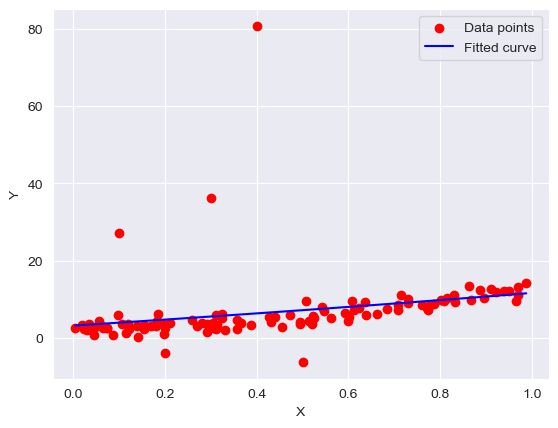

In [153]:
X_ol_fit,Y_ol_fit,error_ol_fit = showNewton(X_ol,Y_ol)

Text(0, 0.5, 'Y')

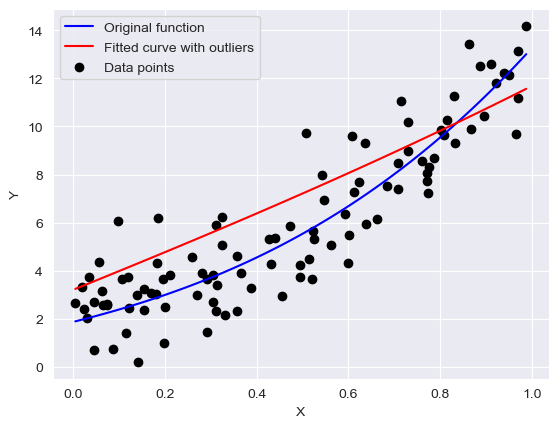

In [155]:
#Cast the original graph and the generated graph
X_comp = jnp.linspace(min(X), max(X), 100)
plt.plot(X_comp,Y_org, color='blue', label='Original function')
plt.plot(X_ol_fit,Y_ol_fit, color='red', label='Fitted curve with outliers')
plt.scatter(X, Y, color='black', label='Data points')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')

In [156]:
def GaussianCalc(X):
    ave = jnp.mean(X)
    std = jnp.std(X)
    return 1/(std*jnp.sqrt(2*jnp.pi))*jnp.exp(-0.5*((X-ave)/std)**2)

In [157]:
def GaussianCurve(error):
    X_axis = jnp.linspace(-1.5*jnp.max(jnp.abs(error)), 1.5*jnp.max(jnp.abs(error)), 100)
    #Gaussian curve
    Y_axis = GaussianCalc(X_axis)
    #Plot the error distribution
    plt.plot(X_axis, Y_axis)
    #plot the vertical line for each one of the actual error value
    for i in range(len(error)):
        plt.axvline(error[i], color='red')
    
    std = jnp.std(error)
    #plot the axvline for the outlier threshold
    plt.axvline(2*std, color='green')
    plt.axvline(-2*std, color='green')

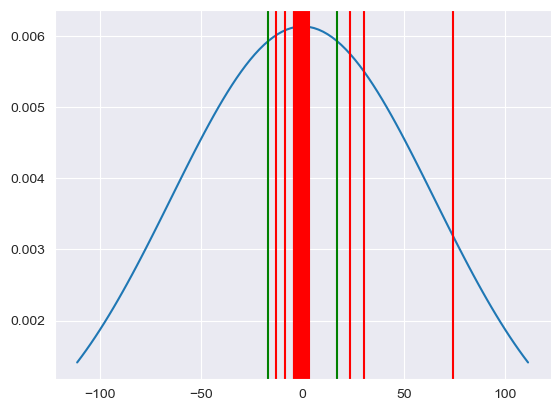

In [158]:
GaussianCurve(error_ol_fit)

In [159]:
#remove outlier based on the gaussian curve
def removeOutliers(X, Y, error):
    ave = jnp.mean(error)
    std = jnp.std(error)
    X_new = []
    Y_new = []
    counter = 0
    for i in range(len(error)):
        if error[i] < 2*std and error[i] > -2*std:
            counter+=1
            X_new.append(X[i])
            Y_new.append(Y[i])
    print(f"Number of outliers removed: {len(error)-counter}")
    return jnp.array(X_new), jnp.array(Y_new)

Number of outliers removed: 3
[[2.         0.91280264 1.0207988 ]
 [0.91280264 0.587914   0.7745943 ]
 [0.587914   0.43288484 0.62333304]]
[[  3.4026961 -13.880257   11.676104 ]
 [-12.405152   70.60981   -67.42911  ]
 [  5.405633  -35.9447     37.41899  ]]
Iteration 1, Parameters: [2.469852  1.4951669 4.9339123]
[[2.         0.91280264 1.0207988 ]
 [0.91280264 0.587914   0.7745943 ]
 [0.587914   0.43288484 0.62333304]]
[[  3.4026961 -13.880257   11.676104 ]
 [-12.405152   70.60981   -67.42911  ]
 [  5.405633  -35.9447     37.41899  ]]
Iteration 2, Parameters: [2.469848  1.4951824 4.933905 ]
[[2.         0.91280264 1.0207988 ]
 [0.91280264 0.587914   0.7745943 ]
 [0.587914   0.43288484 0.62333304]]
[[  3.4026961 -13.880257   11.676104 ]
 [-12.405152   70.60981   -67.42911  ]
 [  5.405633  -35.9447     37.41899  ]]
Iteration 3, Parameters: [2.4698482 1.4951817 4.9339056]
[[2.         0.91280264 1.0207988 ]
 [0.91280264 0.587914   0.7745943 ]
 [0.587914   0.43288484 0.62333304]]
[[  3.402

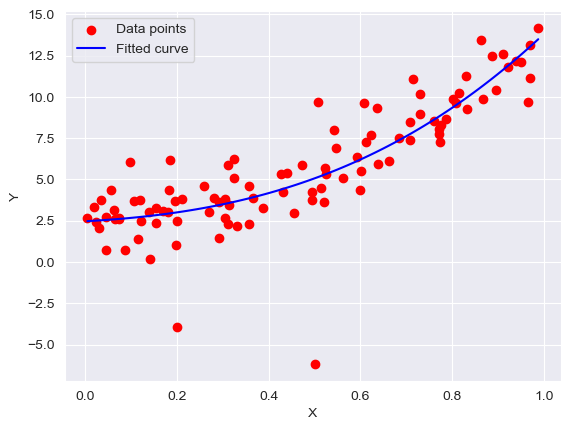

In [160]:
X_new, Y_new = removeOutliers(X_ol, Y_ol, error_ol_fit)
X_ol_removed_fit,Y_ol_removed_fit,error_ol_removed_fit = showNewton(X_new,Y_new)

Text(0, 0.5, 'Y')

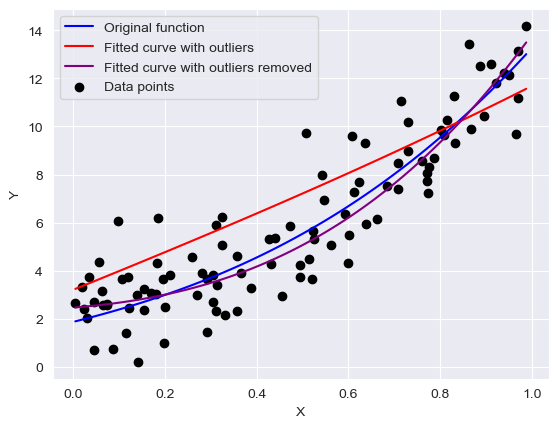

In [164]:
#Cast the original graph and the generated graph
X_comp = jnp.linspace(min(X), max(X), 100)
plt.plot(X_comp,Y_org, color='blue', label='Original function')
plt.plot(X_ol_fit,Y_ol_fit, color='red', label='Fitted curve with outliers')
plt.plot(X_ol_removed_fit,Y_ol_removed_fit, color='purple', label='Fitted curve with outliers removed')
plt.scatter(X, Y, color='black', label='Data points')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')

In [165]:
#Create the weighted loss function
def weighted_loss(params, X, Y, error):
    #for each point multiply the error by the corresponding y value of the gaussian curve
    weighted_error = jnp.abs(error*GaussianCalc(error) ** 20)
    predictions = predict(params, X)
    return jnp.mean((predictions - Y) ** 2 * weighted_error)

In [173]:
# Compute the gradient and Hessian of the loss function
grad_weighted_loss = jit(grad(weighted_loss))
hessian_weighted_loss = hessian(weighted_loss)

# Newton's method for polynomial regression
def newton_method_weighted(X, Y,error, num_iterations=10, tol=1e-6,reg=1e-4):
    #random initialization of the parameters using random function from np
    params = np.random.rand(3)
    for i in range(num_iterations):
        grad_weighted_l = grad_weighted_loss(params, X, Y,error)
        hess_weighted_l = hessian_weighted_loss(params, X, Y,error)
        print(hess_weighted_l)
        # Check if the Hessian is invertible
        #hess_l += reg * jnp.eye(len(params))
        if jnp.linalg.cond(hess_weighted_l) < 1 / jnp.finfo(hess_weighted_l.dtype).eps:
            print(jnp.linalg.inv(hess_weighted_l))
            params_new = params - jnp.linalg.solve(hess_weighted_l, grad_weighted_l)
        else:
            print("Hessian is not invertible.")
            break
        params = params_new

        print(f"Iteration {i+1}, Parameters: {params}",)

    return params

def showNewton_weighted(X, Y,error):
    params = newton_method_weighted(X, Y,error)
    print("Final parameters:", params)

    #get the array of error for each X value
    error = Y - predict(params, X)

    plt.ylim(0, 15)

    # Plot the original data and the fitted curve
    plt.scatter(X, Y, color='red', label='Data points')
    X_fit = jnp.linspace(min(X), max(X), 100)
    Y_fit = predict(params, X_fit)
    plt.plot(X_fit, Y_fit, color='blue', label='Fitted curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    return X_fit,Y_fit,error

[[3.9799246e-27 1.8401625e-27 2.0535798e-27]
 [1.8401625e-27 1.1833649e-27 1.5572096e-27]
 [1.1833650e-27 8.7021469e-28 1.2540507e-27]]
[[ 1.8357921e+27 -7.4148048e+27  6.2010746e+27]
 [-6.6215990e+27  3.6474185e+28 -3.4448344e+28]
 [ 2.8625643e+27 -1.8313414e+28  1.8850371e+28]]
Iteration 1, Parameters: [2.3907592 3.0677147 4.0542307]
[[3.9799246e-27 1.8401625e-27 2.0535798e-27]
 [1.8401625e-27 1.1833649e-27 1.5572096e-27]
 [1.1833650e-27 8.7021469e-28 1.2540507e-27]]
[[ 1.8357921e+27 -7.4148048e+27  6.2010746e+27]
 [-6.6215990e+27  3.6474185e+28 -3.4448344e+28]
 [ 2.8625643e+27 -1.8313414e+28  1.8850371e+28]]
Iteration 2, Parameters: [2.3907607 3.067731  4.0542283]
[[3.9799246e-27 1.8401625e-27 2.0535798e-27]
 [1.8401625e-27 1.1833649e-27 1.5572096e-27]
 [1.1833650e-27 8.7021469e-28 1.2540507e-27]]
[[ 1.8357921e+27 -7.4148048e+27  6.2010746e+27]
 [-6.6215990e+27  3.6474185e+28 -3.4448344e+28]
 [ 2.8625643e+27 -1.8313414e+28  1.8850371e+28]]
Iteration 3, Parameters: [2.3907604 3.06773

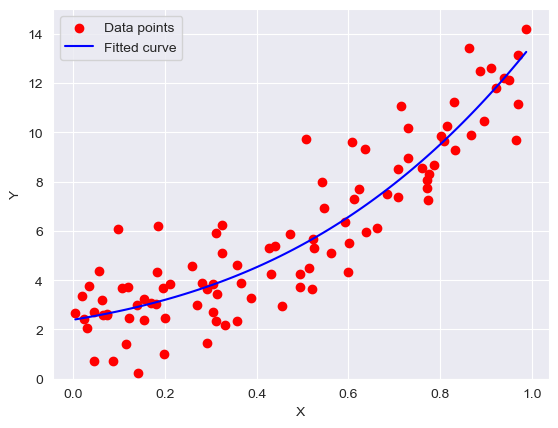

In [174]:
X_ol_weighted_fit,Y_ol_weighted_fit,error_ol_weighted_fit = showNewton_weighted(X_ol,Y_ol,error_ol_fit)

Text(0, 0.5, 'Y')

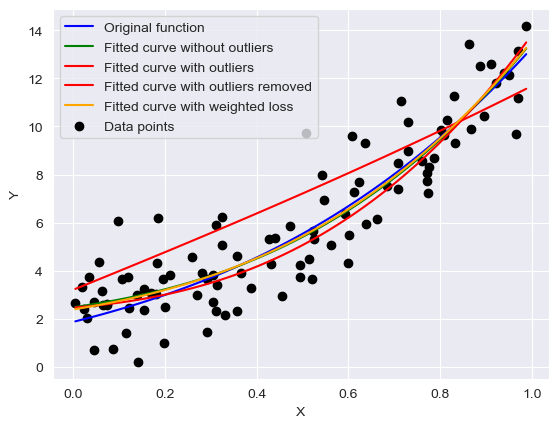

In [175]:
#Cast the original graph and the generated graph
X_comp = jnp.linspace(min(X), max(X), 100)
plt.plot(X_comp,Y_org, color='blue', label='Original function')
plt.plot(X_init_fit,Y_init_fit, color='green', label='Fitted curve without outliers')
plt.plot(X_ol_fit,Y_ol_fit, color='red', label='Fitted curve with outliers')
plt.plot(X_ol_removed_fit,Y_ol_removed_fit, color='red', label='Fitted curve with outliers removed')
plt.plot(X_ol_weighted_fit,Y_ol_weighted_fit, color='orange', label='Fitted curve with weighted loss')
plt.scatter(X, Y, color='black', label='Data points')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')

In [176]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return (jnp.mean((y_true - y_pred) ** 2))

# Generate a common set of X values for comparison
X_comp = jnp.linspace(min(X), max(X), 100)

# Compute RMSE for each fitted curve
rmse_init = float(calculate_rmse(Y_org, Y_init_fit))
rmse_ol = float(calculate_rmse(Y_org, Y_ol_fit))
rmse_ol_removed = float(calculate_rmse(Y_org, Y_ol_removed_fit))
rmse_ol_weighted = float(calculate_rmse(Y_org, Y_ol_weighted_fit))

# Print RMSE values
print(f"RMSE without outliers: {rmse_init}")
print(f"RMSE with outliers: {rmse_ol}")
print(f"RMSE with outliers removed: {rmse_ol_removed}")
print(f"RMSE with weighted loss: {rmse_ol_weighted}")


RMSE without outliers: 0.050125207751989365
RMSE with outliers: 2.0289523601531982
RMSE with outliers removed: 0.11676622182130814
RMSE with weighted loss: 0.036433301866054535


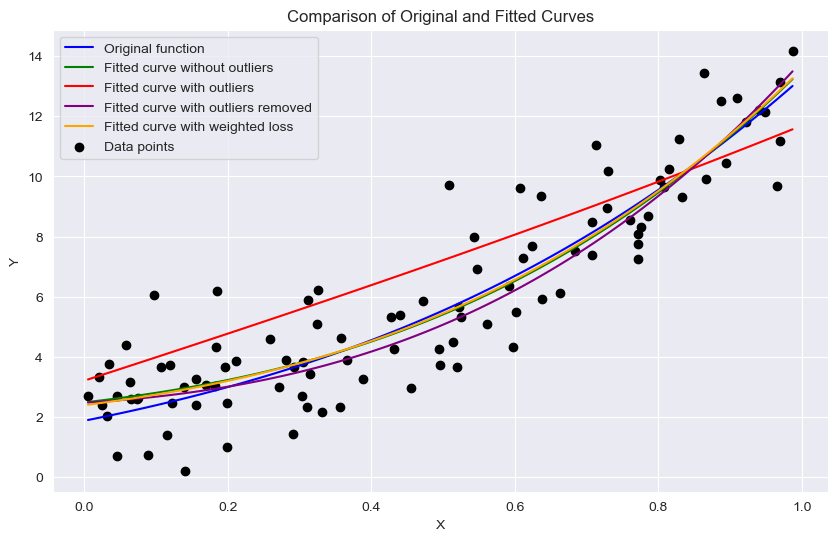

In [177]:
# Plot the original and fitted curves
plt.figure(figsize=(10, 6))
plt.plot(X_comp, Y_org, color='blue', label='Original function')
plt.plot(X_comp, Y_init_fit, color='green', label='Fitted curve without outliers')
plt.plot(X_comp, Y_ol_fit, color='red', label='Fitted curve with outliers')
plt.plot(X_comp, Y_ol_removed_fit, color='purple', label='Fitted curve with outliers removed')
plt.plot(X_comp, Y_ol_weighted_fit, color='orange', label='Fitted curve with weighted loss')
plt.scatter(X, Y, color='black', label='Data points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Comparison of Original and Fitted Curves')
plt.show()


In [178]:
import seaborn as sns
import pandas as pd

# Create a DataFrame for the RMSE values
data = {
    'Curve Type': ['Without Outliers', 'With Outliers', 'Outliers Removed', 'Weighted Loss'],
    'RMSE': [rmse_init, rmse_ol, rmse_ol_removed, rmse_ol_weighted]
}

df = pd.DataFrame(data)


df


,Curve Type,RMSE
0,Without Outliers,0.050125
1,With Outliers,2.028952
2,Outliers Removed,0.116766
3,Weighted Loss,0.036433
